In [2]:

import scipy.spatial
from sklearn import manifold
from sklearn.decomposition import PCA,KernelPCA
from sklearn.preprocessing import StandardScaler

import numpy as np

import os


from itertools import permutations
from matplotlib import pyplot as plt
from matplotlib.pyplot import triplot
from numpy import pi,sin,cos,tan,sqrt
from IPython.core.debugger import Tracer

import triangle as tri
import triangle
import triangle.plot as plot


from scipy.spatial import ConvexHull
from matplotlib.path import Path

import pickle



import torch
import torch.optim as optim

import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torch.nn.functional as F



import cTimer as ctimer
import time
from timeit import default_timer as timer
import pickle

%matplotlib inline



In [3]:
def BCE_accuracy(model,variable,labels):
    net.eval()
    predictions=model(variable).data.numpy()
    predictions[np.where(predictions>0.5)]=1
    predictions[np.where(predictions<=0.5)]=0
    diff=labels-predictions
    correct_prediction=0
    for i in diff:
        if (not i.any()):
            correct_prediction+=1
    net.train()
    return  100*correct_prediction/variable.size()[0],diff

def plot_contour(contour):    
    plot_coords=np.vstack([contour,contour[0]])
    (s,t)=zip(*plot_coords)
    plt.plot(s,t)
    indices=[i for i in range(contour.shape[0])]
    for index,i in enumerate(indices):
        plt.annotate(str(i),(s[index],t[index]))
    



def connectivity_information(triangulation,print_info=False):
    
    segments= tuple(triangulation['segments'].tolist())
    triangles=tuple(triangulation['triangles'].tolist())
    vertices=triangulation['vertices']   
    
    connect_info={str(r):[0 for i in range(len(vertices))] for r in tuple(triangulation['segments'].tolist())}
    for segment in segments:
        for triangle in triangles:
            if set(segment).issubset(set(triangle)):
                connection=set(triangle)-set(segment)
                if print_info: print("segment:",segment,"is connected to:",connection,"to form triangle:",triangle)
                connect_info[str(segment)][tuple(connection)[0]]=1    
    return connect_info



def get_labels(triangulation,connect_info):
    indices=[]
    vertices=list(range(triangulation['vertices'].shape[0]))
    for i in triangulation['segments']:
           indices.append(set(vertices)-set(i)) 
    labels=[]
    list_values=list(connect_info.values())
    for i in range(len(list_values)):
        for j in indices[i]:
            labels.append(list_values[i][j])
    return  labels


In [4]:

def rot(theta):
    return np.array([[cos(theta),-sin(theta)],     
                     [sin(theta),cos(theta)]])






def get_reference_polygon(nb_of_points,plot=False):
    angles=np.empty(nb_of_points)
    points=np.empty([nb_of_points,2])
    plot_coords=np.empty([nb_of_points,2])
    indices=[]
    angle_division=2*pi/nb_of_points
   
    for i in range(nb_of_points):
        angle=i*angle_division
        angles[i]=angle
        point=np.array([1,0]) #pick edge length of 1
        points[i]=np.dot(rot(angle),point.T)  #rotate it according to the  chosen angle
        indices.append(i)
   
    if plot==True:
        plot_coords=np.vstack([points,points[0]])
        (s,t)=zip(*plot_coords)
        plt.plot(s,t)
        for index,i in enumerate(indices):
            plt.annotate(str(i),(s[index],t[index]))
    
    return points



def generate_contour(nb_of_points,plot=False):
    
    angles=np.empty(nb_of_points)
    points=np.empty([nb_of_points,2])
    plot_coords=np.empty([nb_of_points,2])
    indices=[]
    angle_division=2*pi/nb_of_points
   
    for i in range(nb_of_points):
        angle=((i+1)*angle_division-i*angle_division)*np.random.random_sample()+i*angle_division
        angles[i]=angle
        point=np.array([np.random.uniform(0.3,1),0]) #pick random point at (1,0)
       #point=np.array([1,0]) #pick edge length of 1

        points[i]=np.dot(rot(angle),point.T)  #rotate it according to the  chosen angle
        indices.append(i)
   
    if plot==True:
        plot_coords=np.vstack([points,points[0]])
        (s,t)=zip(*plot_coords)
        plt.plot(s,t)
        for index,i in enumerate(indices):
            plt.annotate(str(i),(s[index],t[index]))
    
    return points



def get_barycenter(contour):
    return np.array([contour[:,0].sum()/contour.shape[0],contour[:,1].sum()/contour.shape[0]])


def apply_procrustes(polygon_points,plot=False):  
    
    # Get reference polygona and adjust any random poygon to that
    ref_polygon=get_reference_polygon(polygon_points.shape[0])
    
    
    #Mean of each coordinate
    mu_polygon = polygon_points.mean(0)
    mu_ref_polygon = ref_polygon.mean(0)
    
    #Centralize data to the mean 
    centralised_ref_polygon_points = ref_polygon-mu_ref_polygon
    centralised_polygon_points = polygon_points-mu_polygon
    
    #Squared sum of X-mean(X)
    ss_ref_polygon_points = (centralised_ref_polygon_points**2.).sum()
    ss_polygon_points = (centralised_polygon_points**2.).sum()

       
    #Frobenius norm of X
    norm_ss_ref_polygon_points = np.sqrt(ss_ref_polygon_points)
    norm_ss_polygon_points = np.sqrt(ss_polygon_points)

    
    # scale to equal (unit) norm
    centralised_ref_polygon_points /=norm_ss_ref_polygon_points     
    centralised_polygon_points /=norm_ss_polygon_points
        
    
    #Finding best rotation to superimpose on regular triangle
    #Applying SVD to the  matrix 
    A = np.dot(centralised_ref_polygon_points.T, centralised_polygon_points)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V=Vt.T
    R = np.dot(V,U.T)
    
  
    traceTA = s.sum()
    d = 1 - traceTA**2
    b = traceTA * norm_ss_ref_polygon_points / norm_ss_polygon_points    
    indices=[i for i in range(polygon_points.shape[0])]
    
   

    polygon_transformed =norm_ss_ref_polygon_points*traceTA*np.dot(centralised_polygon_points,R)+mu_ref_polygon

    if plot==True:
        plot_coords=np.vstack([polygon_transformed,polygon_transformed[0]])
        (s,t)=zip(*plot_coords)
        plt.plot(s,t)
        for index,i in enumerate(indices):
            plt.annotate(str(i),(s[index],t[index]))
    
    return polygon_transformed
        
    

In [5]:

def contains_points(triangle,polygon):
    hull=ConvexHull(triangle)
    hull_path=Path(triangle[hull.vertices])
    set_polygon=set(tuple(i) for i in polygon)
    set_triangle=set(tuple(i) for i in triangle)
    #print(set_polygon,set_triangle)
    difference=set_polygon-set_triangle
    
    if len(difference)==0:
        return False

    for i in difference:
        if hull_path.contains_point(i):
            return True
            break
    return False




def compute_edge_lengths(pt1,pt2):
    return np.linalg.norm(pt1-pt2)

def compute_edge_lengths2(triangle):
    edgelengths2=np.empty([2,3])
    for i in range(2):
        for j in range(i+1,3):
            eij=triangle[j]-triangle[i]
            edgelengths2[i][j]=np.dot(eij,eij)
    return edgelengths2
    


def compute_triangle_normals(triangle):
   
    e01=triangle[1]-triangle[0]
    e02=triangle[2]-triangle[0]
    
    e01_cross_e02=np.cross(e01,e02)
    
    return e01_cross_e02


def compute_triangle_area(triangle):
   
    e01=triangle[1]-triangle[0]
    e02=triangle[2]-triangle[0]
    
    e01_cross_e02=np.cross(e01,e02)
    
    # Omit triangles that are inverted (out of the domain)
    if e01_cross_e02<0:
        return 0
        
    
    e01_cross_e02_norm=np.linalg.norm(e01_cross_e02)

        
    return e01_cross_e02_norm/2

def compute_triangle_quality(triangle,polygon=None):
    
    if polygon is None:
        polygon=triangle
    
    # The incoming triangle has edged [p0,p1] which is an edge and p2 is the connection
    polygon_angles=get_polygon_angles(polygon)
    
    indices=[]


    for point in triangle: 
        for index,point_in_polygon in enumerate(polygon):
              if np.allclose(point,point_in_polygon):
                    indices.append(index)
                
    p0,p1,p2=indices[0],indices[1],indices[2]
    
    neighbor_points=connection_indices(p2,get_contour_edges(polygon))
    
    # Checking if edges of connected poiints form an angle bigger than the polygon angles
    if (polygon_angles[p0]<calculate_angle(polygon[p0],polygon[p1],polygon[p2]) 
        or polygon_angles[p1]<calculate_angle(polygon[p1],polygon[p0],polygon[p2])):
        #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
        return 0
    
    
    if( polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[0]],polygon[p0])
        or polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[0]],polygon[p1])
    ):
        #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
        return 0
    
    if( polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[1]],polygon[p0])
        or polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[1]],polygon[p1])):
        #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
        return 0
    
    factor=4/sqrt(3)
    area=compute_triangle_area(triangle)
   
    if area==0:
        return 0
    
    if contains_points(triangle,polygon):
        return 0
    
    
    
    #edgelengths=np.empty([triangle.shape[0],1])
    
    #for i,_ in enumerate(triangle):
     #   edgelengths[i]=compute_edge_length(triangle[i],triangle[(i+1)%3])
    
    #sum_edge_lengths=edgelengths.sum() 
    #factor=4/sqrt(3)*3/sum_edge_lengths
    
    sum_edge_lengths=0
    edge_length2=compute_edge_lengths2(triangle)
    for i in range(2):
        for j in range(i+1,3):
            sum_edge_lengths+=edge_length2[i][j]
    
    
    
    lrms=sqrt(sum_edge_lengths/3)
    lrms2=lrms**2
    quality=area/lrms2
    
    return quality*factor



def compute_minimum_quality_triangle(triangle,polygon=None,get_mean=False):
    if polygon is None:
        polygon=triangle
    
    # The incoming triangle has edged [p0,p1] which is an edge and p2 is the connection
    polygon_angles=get_polygon_angles(polygon)
    
    indices=[]


    for point in triangle: 
        for index,point_in_polygon in enumerate(polygon):
              if np.allclose(point,point_in_polygon):
                    indices.append(index)
                
    p0,p1,p2=indices[0],indices[1],indices[2]
    
    neighbor_points=connection_indices(p2,get_contour_edges(polygon))
    
    # Checking if edges of connected poiints form an angle bigger than the polygon angles
    if (polygon_angles[p0]<calculate_angle(polygon[p0],polygon[p1],polygon[p2]) 
        or polygon_angles[p1]<calculate_angle(polygon[p1],polygon[p0],polygon[p2])):
        #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
        return 0
    
    
    if( polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[0]],polygon[p0])
        or polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[0]],polygon[p1])
    ):
        #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
        return 0
    
    if( polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[1]],polygon[p0])
        or polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[1]],polygon[p1])):
        #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
        return 0
    
    area=compute_triangle_area(triangle)
   
    if area==0:
        return 0
    
    if contains_points(triangle,polygon):
        return 0
    
    triangles_in_mesh=[]
    triangles_in_mesh.append(triangle)
    contour_connectivity=get_contour_edges(polygon)
    contour_connectivity=np.vstack([contour_connectivity,[p0,p2],[p1,p2]])
    hole=np.array([(triangle.sum(0))/3])
    shape=dict(holes=hole,vertices=polygon,segments=contour_connectivity)
    t = tri.triangulate(shape, 'pq0')
    
    Invalid_triangulation=False

    try:   
        for triangle_index in t['triangles']:
            triangles_in_mesh.append(polygon[np.asarray([triangle_index])])
    except :
        print("Invalid triangulation",p0,p1,p2)
        Invalid_triangulation=True
        
    triangle_qualities=[]
    for triangle in triangles_in_mesh:
        triangle.resize(3,2)
        triangle_quality=compute_triangle_quality(triangle)
        triangle_qualities.append(triangle_quality)
    
    if Invalid_triangulation:
        mean_quality,minimum_quality=0,0
    else:
        triangle_qualities=np.array(triangle_qualities)
        mean_quality=triangle_qualities.mean()
        minimum_quality=triangle_qualities.min()

    

    if get_mean:
        return mean_quality
    else:
        return minimum_quality





# Quality of elements formed by connecting each edge with one of the other points of the contour

def quality_matrix(polygon,compute_minimum=True ,normalize=False,mean=False):
    polygon=apply_procrustes(polygon,False)

    contour_connectivity=np.array(list(tuple(i) for i in get_contour_edges(polygon)))
    
    
    
    
    quality_matrix=np.zeros([contour_connectivity.shape[0],polygon.shape[0]])
    area_matrix=np.zeros([contour_connectivity.shape[0],polygon.shape[0]])
    normals_matrix=np.zeros([contour_connectivity.shape[0],polygon.shape[0]])

    list_of_triangles=[]
    
    for index,edge in enumerate(contour_connectivity):
        # Not omitting non triangles because either way their quality is zero
        triangles_to_edge_indices=[[*edge,i] for i in range(polygon.shape[0]) ]
        
        

        #print(triangles_to_edge_indices)
        triangles_to_edge_indices=np.asarray(triangles_to_edge_indices)
        triangles=polygon[triangles_to_edge_indices]
        list_of_triangles.append(triangles)
        
    
    list_of_triangles=np.array(list_of_triangles)
    
    if compute_minimum:
        for i,triangles in enumerate(list_of_triangles):
            for j,triangle in enumerate(triangles):
                quality_matrix[i,j]=compute_minimum_quality_triangle(triangle,polygon)
    else:
         for i,triangles in enumerate(list_of_triangles):
            for j,triangle in enumerate(triangles):
                if mean:
                    quality_matrix[i,j]=compute_triangle_quality(triangle,polygon,get_mean=True)
                else: 
                    quality_matrix[i,j]=compute_triangle_quality(triangle,polygon)
    
            #area_matrix[i,j]=compute_triangle_area(triangle)
            #normals_matrix[i,j]=compute_triangle_normals(triangle)

            
    
    sum_of_qualities=quality_matrix.sum(1)

    if normalize is True:
        for i,_ in enumerate(quality_matrix):
            quality_matrix[i]/=sum_of_qualities[i]
    
    return quality_matrix,normals_matrix




    
    
    

In [6]:
def check_edge_validity(edge,polygon,set_edges,interior_edges):        
    # Check if new edges are already in the set
    found_in_set=False
    found_in_interior_set=False
    for index in range(len(polygon)):
        occuring_index=index

        edge1,edge2=tuple(permutations((edge[0],index))),tuple(permutations((edge[1],index)))
        condition1= edge1[0] in set_edges or edge1[1] in set_edges
        condition2= edge2[0] in set_edges or edge2[1] in set_edges
        condition3= edge1[0] in interior_edges or edge1[1] in interior_edges
        condition4= edge2[0] in interior_edges or edge2[1] in interior_edges
    
        
            # both edges are found in the list of set of edges (Invalid)
        if (condition1 and condition2): 
            found_in_set=True
            occuring_index=index
            
        
        # both edges are found in the list of interior edges created
        if (condition3 and condition4):
            found_in_interior_set=True
            occuring_index=index
            
        if found_in_interior_set or found_in_set:
            break
    return found_in_interior_set,found_in_set,occuring_index

def triangulate(polygon,ordered_quality_matrix,recursive=True):
    set_edges=set(tuple(i) for i in get_contour_edges(polygon))
    interior_edges=set()
    set_elements=set()
    set_locked_vertices=set()
    set_forbidden_intersections=set()
    polygon_angles=get_polygon_angles(polygon)

    print("initial set edges:", set_edges)
    


    for edge in ordered_quality_matrix.keys():
        
        
        
        found_in_interior_set,found_in_set,index=check_edge_validity(edge,polygon,set_edges,interior_edges)

        for qualities_with_edges in ordered_quality_matrix[edge][0]:
            
            element_created=False
           
            target_vtx=qualities_with_edges[1]
            
            if target_vtx==edge[0] or target_vtx==edge[1]:
                continue
           
            print("Edge:",edge,"targeting:",target_vtx)
        
            if found_in_interior_set:
                element=(edge[0],edge[1],index)  
                set_elements.add(element)
                print("Element inserted:",element)
                continue
        
            if found_in_set and not found_in_interior_set:    
                if(index != target_vtx):
                    print('found',(edge[0],index),(edge[1],index),"Canceling creation")
                    continue        
        
        
        
        
            # Passed edges checking 
            # Proceed to check vertices
            temp_element=(edge[0],edge[1],target_vtx)
            
            # Cehcking element normals to avoid inverted elements
            element_indices=np.asarray([edge[0],edge[1],target_vtx])
            if compute_triangle_normals(polygon[element_indices])<0:
                continue
            
            # Checking if the element contains other points of the polygon inside
            if contains_points(polygon[element_indices],polygon):
                continue
            
                            
            p0,p1,p2=edge[0],edge[1],target_vtx
    
            neighbor_points=connection_indices(p2,get_contour_edges(polygon))
    
            # Checking if edges of connected poiints form an angle bigger than the polygon angles
            if (polygon_angles[p0]<calculate_angle(polygon[p0],polygon[p1],polygon[p2]) 
            or polygon_angles[p1]<calculate_angle(polygon[p1],polygon[p0],polygon[p2])):
            #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
                 continue
    
    
            if( polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[0]],polygon[p0])
           or polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[0]],polygon[p1])
            ):
                continue
    
            if( polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[1]],polygon[p0])
            or polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[1]],polygon[p1])):
            #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
                continue
         
        
        
            quality=compute_minimum_quality_triangle(polygon[element_indices],polygon)
            if quality==0 or quality<1e-2:
                continue
            
            print(temp_element)
            existing_element=False
            for element in set_elements:
                if set(temp_element)==set(element):
                    print("Element {} already in set".format(element))
                    existing_element=True
                    break
            if existing_element:
                break
            
            
            
            if target_vtx in set_locked_vertices:
                print(" Target vertex {} is locked".format(target_vtx))
                continue
            set_elements.add(temp_element)

        
    
            # Check if a locked vertex was created after the creation of the element
            # If so, add it to the list
            #Tracer()()
            Found_locked_vertex=False
            for vertex in temp_element:
                _ ,isclosed = is_closed_ring(vertex,set_elements,*connection_indices(vertex,get_contour_edges(polygon)))
                if isclosed and vertex not in set_locked_vertices:
                    print("Vertex locked:",vertex)
                    Found_locked_vertex=True
                    set_locked_vertices.add(vertex)
            set_elements.remove(temp_element)
            
        
        
            # Locking the vertices and checking if the connection is with a locked vertex has been checked/
            # Proceeding to check if both internal edges intersect with other internal edges
            internal_edge1=(edge[0],target_vtx)
            internal_edge2=(edge[1],target_vtx)
            set_a,set_b=get_intermediate_indices(target_vtx,polygon,edge[0],edge[1])
        
            internal_condition1= internal_edge1 in set_forbidden_intersections or tuple(reversed(internal_edge1)) in set_forbidden_intersections
                                                                        
            internal_condition2=internal_edge2 in set_forbidden_intersections or tuple(reversed(internal_edge2)) in set_forbidden_intersections
                                                                            
    
                                                                                   
            internal_intersection=False
            if internal_condition1 or  internal_condition2:
                print("edges :",internal_edge1, "and",internal_edge2,"intersecting")
                print("Abandoning creation of element",temp_element)
                internal_intersection=True
        
     
            if internal_intersection:
                for vtx in temp_element:
                    if Found_locked_vertex and vtx in set_locked_vertices:
                        print("Unlocking vertex",vtx)
                        set_locked_vertices.remove(vtx)                    
                continue
        
        
        
            # Create the element
            element=temp_element
        
            # Add to set of edges all the forbidden intersections after the creation of the element
            
            for i in set_a:
                for j in set_b:
                    set_forbidden_intersections.add((i,j))
            #print("set of forbidden inter section edges updated:",set_forbidden_intersections)
    
                
        
        
        # New edges after creation of the element
   
            new_edge1=(edge[0],target_vtx)
            new_edge2=(edge[1],target_vtx)
        
            if new_edge1 not in set_edges and tuple(reversed(new_edge1)) not in set_edges:
                set_edges.add(new_edge1)
                interior_edges.add(new_edge1)
                print("edges inserted:",new_edge1)
                print("set of interior edges updated:",interior_edges)
                print("set of edges updated:",set_edges)
            if new_edge2 not in set_edges and tuple(reversed(new_edge2)) not in set_edges:    
                set_edges.add(new_edge2)
                interior_edges.add(new_edge2)
                print("edges inserted:",new_edge2)
                print("set of interior edges updated:",interior_edges)
                print("set of edges updated:",set_edges)
            
        
    
    
            # Checking list of elements to see whether the were created or were already there
            #for element_permutation in tuple(permutations(element)):
                #if element_permutation in set_elements:
                 #   print("Element {} already in set".format(element))
                  #  break
            #else:
            set_elements.add(element)
            indices=np.asarray(element)
            print("element inserted:",element)
            element_created=True
            break
        if element_created:
            continue
        
        
            
    
    
    triangulated={'segment_markers': np.ones([polygon.shape[0]]), 'segments':np.array(get_contour_edges(polygon)), 'triangles': np.array(list( list(i) for i in set_elements)),
                  'vertex_markers': np.ones([polygon.shape[0]]), 'vertices': polygon}
    plot.plot(plt.axes(), **triangulated)
    print("Final edges:",set_edges)
    print("Elements created:",set_elements)
    print("Set of locked vertices:", set_locked_vertices)
    
    
    # find open vertices
    for element in set_elements:
        for vertex in  element:
                    _ ,isclosed = is_closed_ring(vertex,set_elements,*connection_indices(vertex,get_contour_edges(polygon)))
                    if isclosed and vertex not in set_locked_vertices:
                        print("Vertex locked:",vertex)
                        Found_locked_vertex=True
                        set_locked_vertices.add(vertex)
    set_open_vertices=set(range(len(polygon)))-set_locked_vertices
    print("Set of open vertices:", set_open_vertices)
    set_edges.clear(),set_locked_vertices.clear(),set_forbidden_intersections.clear
    if recursive:
        sub_polygon_list=check_for_sub_polygon(set_open_vertices,interior_edges,set_elements,polygon)

        for sub_polygon_indices in sub_polygon_list:
            if len(sub_polygon_indices)>=4:
                polygon_copy=polygon.copy()
                sub_polygon=np.array(polygon_copy[sub_polygon_indices])
                sub_quality,_=quality_matrix(sub_polygon,compute_minimum=True,normalize=False)
                sub_order_matrix=order_quality_matrix(sub_quality,sub_polygon)
                print(sub_quality,sub_order_matrix)
                triangulate(sub_polygon,sub_order_matrix)


    

    
    
def pure_triangulate(polygon,ordered_quality_matrix,recursive=True):
    set_edges=set(tuple(i) for i in get_contour_edges(polygon))
    interior_edges=set()
    set_elements=set()
    set_locked_vertices=set()
    set_forbidden_intersections=set()
    polygon_angles=get_polygon_angles(polygon)
    check_edge_validity_time,check_for_existing_element=0,0
    #print("initial set edges:", set_edges)
    

   
    for edge in ordered_quality_matrix.keys():
        
        start=timer()
        found_in_interior_set,found_in_set,index=check_edge_validity(edge,polygon,set_edges,interior_edges)
        stop=timer()
        check_edge_validity_time+=stop-start
        
        for qualities_with_edges in ordered_quality_matrix[edge][0]:
            
            element_created=False
           
            target_vtx=qualities_with_edges[1]
            

        
            if found_in_interior_set:
                element=(edge[0],edge[1],index)  
                set_elements.add(element)
                #print("Element inserted:",element)
                continue
        
            if found_in_set and not found_in_interior_set:    
                if(index != target_vtx):
                    continue        
        
        
        
            # Passed edges checking 
            # Proceed to check vertices
            temp_element=(edge[0],edge[1],target_vtx)

            existing_element=False
           
            for element in set_elements:
                if set(temp_element)==set(element):
                    existing_element=True
                    break
            
            if existing_element:
                break
        
            
            
            
            if target_vtx in set_locked_vertices:
                #print(" Target vertex {} is locked".format(target_vtx))
                continue
            set_elements.add(temp_element)

        
    
            # Check if a locked vertex was created after the creation of the element
            # If so, add it to the list
            #Tracer()()
            
            Found_locked_vertex=False
#            timer1=timer()
            for vertex in temp_element:
                _ ,isclosed = is_closed_ring(vertex,set_elements,*connection_indices(vertex,get_contour_edges(polygon)))
                if isclosed and vertex not in set_locked_vertices:
                    #print("Vertex locked:",vertex)
                    Found_locked_vertex=True
                    set_locked_vertices.add(vertex)
  #          timer2=timer()
            checking_locked_vertices=time2-time1
            set_elements.remove(temp_element)

            
        
        
            # Locking the vertices and checking if the connection is with a locked vertex has been checked/
            # Proceeding to check if both internal edges intersect with other internal edges
            internal_edge1=(edge[0],target_vtx)
            internal_edge2=(edge[1],target_vtx)
            set_a,set_b=get_intermediate_indices(target_vtx,polygon,edge[0],edge[1])
        
            internal_condition1= internal_edge1 in set_forbidden_intersections or tuple(reversed(internal_edge1)) in set_forbidden_intersections
                                                                        
            internal_condition2=internal_edge2 in set_forbidden_intersections or tuple(reversed(internal_edge2)) in set_forbidden_intersections
                                                                            
    
                                                                                   
            internal_intersection=False
            

            if internal_condition1 or  internal_condition2:
                #print("edges :",internal_edge1, "and",internal_edge2,"intersecting")
                #print("Abandoning creation of element",temp_element)
                internal_intersection=True
        
     
            if internal_intersection:
                for vtx in temp_element:
                    if Found_locked_vertex and vtx in set_locked_vertices:
                        #print("Unlocking vertex",vtx)
                        set_locked_vertices.remove(vtx)                    
                continue

        
        
        
            # Create the element
            element=temp_element
        
            # Add to set of edges all the forbidden intersections after the creation of the element
            
            for i in set_a:
                for j in set_b:
                    set_forbidden_intersections.add((i,j))
            #print("set of forbidden inter section edges updated:",set_forbidden_intersections)
    
                
        
        
        # New edges after creation of the element
   
            new_edge1=(edge[0],target_vtx)
            new_edge2=(edge[1],target_vtx)
        
            if new_edge1 not in set_edges and tuple(reversed(new_edge1)) not in set_edges:
                set_edges.add(new_edge1)
                interior_edges.add(new_edge1)
                #print("edges inserted:",new_edge1)
                #print("set of interior edges updated:",interior_edges)
                #print("set of edges updated:",set_edges)
            if new_edge2 not in set_edges and tuple(reversed(new_edge2)) not in set_edges:    
                set_edges.add(new_edge2)
                interior_edges.add(new_edge2)
                #print("edges inserted:",new_edge2)
                #print("set of interior edges updated:",interior_edges)
                #print("set of edges updated:",set_edges)
            
        
    
    
         
            set_elements.add(element)
            indices=np.asarray(element)
                #print("element inserted:",element)
            element_created=True
            
            if element_created:
                break
            else:
                continue
        
           
    
#    triangulated={'segment_markers': np.ones([polygon.shape[0]]), 'segments':np.array(get_contour_edges(polygon)), 'triangles': np.array(list( list(i) for i in set_elements)),
#                  'vertex_markers': np.ones([polygon.shape[0]]), 'vertices': polygon}
#    plot.plot(plt.axes(), **triangulated)
    #print("Final edges:",set_edges)
    #print("Elements created:",set_elements)
    #print("Set of locked vertices:", set_locked_vertices)
    
    
    # find open vertices
    for element in set_elements:
        for vertex in  element:
                _ ,isclosed = is_closed_ring(vertex,set_elements,*connection_indices(vertex,get_contour_edges(polygon)))
                if isclosed and vertex not in set_locked_vertices:
                        #print("Vertex locked:",vertex)
                        Found_locked_vertex=True
                        set_locked_vertices.add(vertex)
    set_open_vertices=set(range(len(polygon)))-set_locked_vertices
    #print("Set of open vertices:", set_open_vertices)
    set_edges.clear(),set_locked_vertices.clear(),set_forbidden_intersections.clear
    if recursive and len(set_open_vertices)>=4:
        sub_polygon_list=check_for_sub_polygon(set_open_vertices,interior_edges,set_elements,polygon)
#
        for sub_polygon_indices in sub_polygon_list:
            if len(sub_polygon_indices)>=4:
                polygon_copy=polygon
                sub_polygon=np.array(polygon_copy[sub_polygon_indices])
                sub_quality,_=quality_matrix(sub_polygon,compute_minimum=True,normalize=False)
                sub_order_matrix=order_quality_matrix(sub_quality,sub_polygon)
                #print(sub_quality,sub_order_matrix)
                pure_triangulate(sub_polygon,sub_order_matrix)
#

    
def order_quality_matrix(_quality_matrix,_polygon):

    #  Create the quality matrix in accordance with the edges
    quality_board=[(q,index)  for qualities in _quality_matrix for index,q in enumerate(qualities)]
    quality_board=np.array(quality_board)
    #print("Quality board not resized:",quality_board)

    quality_board.resize(len(get_contour_edges(_polygon)),len(_polygon),2)
    quality_board=dict(zip(list(tuple(i) for i in get_contour_edges(_polygon)),quality_board))
    
    
    #sorted_quality_board={i[0]:i[1] for i in sorted(board.items(),key=lambda x: max(x[1]),reverse=True)}
    #print("Quality board")
    #for keys,items in quality_board.items():
    #    print(keys,items)
    edge_quality=quality_board[(0,1)]
    edge_quality=edge_quality[np.lexsort(np.fliplr(edge_quality).T)]




    for i in quality_board.keys():
        quality_board[i]=quality_board[i][np.lexsort(np.fliplr(quality_board[i]).T)]
        quality_board[i]=quality_board[i][::-1]
        quality_board[i][:,1]=quality_board[i][:,1].astype(int)
    
    edge=[]
    max_quality=[]
    listing=[]
    for keys,values in quality_board.items():
        listing.append([keys,max(values[:,0])])
    
    listing=np.array(listing)
    listing=listing[np.lexsort(np.transpose(listing)[::-3]).T]
    listing=listing[::-1]
    ordered_indices=listing[:,0]

    ordered_quality_matrix={}

    for i in ordered_indices:
        ordered_quality_matrix[i]=[tuple(zip(quality_board[i][:,0],quality_board[i][:,1].astype(int)))]
    
    return ordered_quality_matrix    
    
    
    

In [7]:
# Function to get the list of edges of a polygon
def get_contour_edges(polygon):
    contour_connectivity=np.array([[i,(i+1)%polygon.shape[0]] for i in range(polygon.shape[0])])
    return contour_connectivity



# Function to return indices that are connected to a vertex
def connection_indices(vertex,edges):   
    indices=[]
    for edge in edges:
        if vertex in edge:

            if edge[0] == vertex:
                indices.append(edge[1])
            else:
                indices.append(edge[0])

    return indices

# Function to calculate and angle:
def calculate_angle(p0,p1,p2):
    v0 = p1 - p0
    v1 = p2 - p0
    
    
    normal=compute_triangle_normals([p0,p1,p2])
    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    angle=abs(angle)
    #unit_v0=v0 / np.linalg.norm(v0)
    #unit_v1=v1 / np.linalg.norm(v1)
    #angle=np.arccos(np.clip(np.dot(unit_v0, unit_v1), -1.0, 1.0))
    
    return np.degrees(angle)



# Function to calculate the angles of a polygon
def get_polygon_angles(polygon):
    angles=[]
    for index,point in enumerate(polygon):
        p0=point        
        neighbor_points=connection_indices(index,get_contour_edges(polygon))
        #print("neighbor points",neighbor_points)
        indices=np.asarray(neighbor_points)
        p1,p2=polygon[indices]
        angle=calculate_angle(p0,p1,p2)
        if index !=0:
            triangle_normal=compute_triangle_normals([p0,p1,p2])
        else:
            triangle_normal=compute_triangle_normals([p1,p0,p2])

            
        if triangle_normal>0:
            angle=360-angle
        
        angles.append(angle)
    return angles
    



def is_closed_ring(vtx,set_of_elements,*adj_vtx):
    contour_edge1=(vtx,adj_vtx[0])
    contour_edge2=(vtx,adj_vtx[1])
    visited_elements=set_of_elements.copy()
    
    target_edge=contour_edge1
    
    edges_found=[]
    edges_found.append(contour_edge1)

    proceed=True
    
    while proceed:
        
        if not visited_elements:
            break
        
        remaining_edge,found_element=edge2elem(target_edge,visited_elements)
        
        if found_element is None:
            #print("stopped")
            proceed=False
            break
            
        visited_elements.remove(found_element)
        edges_found.append(remaining_edge)
        target_edge=remaining_edge
    
    
                
    #print(set(edges_found))
    found_contour_edge1,found_contour_edge2=False,False
    found_contour_edges=False

    # Checking if both contour edges area contained in the set of edges acquired
    
    for edge in edges_found:
        condition1= contour_edge1[0] in set(edge) and contour_edge1[1] in set((edge))
        condition2= contour_edge2[0] in set(edge) and contour_edge2[1] in set((edge))
        if condition1:
            #print("found ",contour_edge1)
            found_contour_edge1=True
        if condition2:
            #print("found",contour_edge2)
            found_contour_edge2=True
            
    if found_contour_edge1 and found_contour_edge2:
        found_contour_edges=True
        #print("found both of contour edges in set")
    
    visited_elements.clear()
    return edges_found,found_contour_edges
    
    
    
# Finds element containing the edge and exits (does not give the full list of elements)   
# Serve is_one_ring function
def edge2elem(edge,set_of_elements):
    found=False
    Found_element=()
    Remaining_edge=()
  
    for element in set_of_elements.copy():
        
        if edge[0] in  set(element) and edge[1] in set(element): 
            #print("Edge {} is part of element {}".format(edge,element))
            Found_element=element
            Remaining_index=set(element)-set(edge)
            Remaining_index=list(Remaining_index)
            Remaining_edge=(edge[0],Remaining_index[0])
            #print(" Remaining edge is {}".format(Remaining_edge))
            break 
        else:
            Found_element=None
            Remaining_edge=None
    return  Remaining_edge,Found_element 

# Departing from a target vertex connected with and edge get all intermediate  indices from one side and other
def get_intermediate_indices(target_vtx,polygon,*edge):
    
    set_1=set()
    set_2=set()
    
    
    contour_edges=get_contour_edges(polygon)
    
    
    # Depart from target vertex and get neighbor indices
    neighbors=connection_indices(target_vtx,contour_edges)
    found_vertex1,found_vertex2=neighbors[0],neighbors[1]
    #print("found vertices:",found_vertex1,found_vertex2)

    
    # Include them into seperate lists
    set_1.add(found_vertex1)
    set_2.add(found_vertex2)
    
    visited_vertex=target_vtx
      
    
    while found_vertex1!=edge[0] and found_vertex1!=edge[1]:
        visiting_vertex=found_vertex1
        neighbors=connection_indices(visiting_vertex,contour_edges)
        for index in neighbors:
            if index !=  visited_vertex:
                set_1.add(index)
                found_vertex1=index
                #print("Found vertex:",found_vertex1)     
        visited_vertex=visiting_vertex
        
    #print("Start  looking the other way")
    
    # Resetting to go the other way
    visited_vertex=target_vtx

    while found_vertex2!=edge[0] and found_vertex2!=edge[1]:
        visiting_vertex=found_vertex2
        neighbors=connection_indices(visiting_vertex,contour_edges)
        for index in neighbors:
            if index !=  visited_vertex:
                set_2.add(index)
                found_vertex2=index
                #print("Found vertex:",found_vertex2)     
        visited_vertex=visiting_vertex
    
                
                
                
  
    return set_1,set_2
                
            
        
    
    

In [8]:
def polygon_2_vtx(starting_vertex,edges_to_visit):
    from  more_itertools import unique_everseen
    
    if not edges_to_visit:
        return
    
    
    closed=False

                
    #print("Edges to visit:",edges_to_visit)
    subpolygon=[]
    
                
    found_vertex=starting_vertex
    
    while not closed:
        for index,edge in enumerate(edges_to_visit.copy()):
            visiting_vertex=found_vertex
            
           
            #if visiting_vertex not in set(edge) and index==len(edges_to_visit.copy()):
               # Tracer()()
                #print("Not found in list of edges")
                #closed=True
                #break
            if visiting_vertex not in set(edge):
                continue
            subpolygon.append(visiting_vertex)
                
                                
            #print("Visiting vertex",visiting_vertex)
            
            found_starting_vtx=False
            subpolygon.append(found_vertex)
            
            
            #print(visiting_vertex," in ", edge)
                
                
            for index in set(edge):
                if visiting_vertex!= index:
                    found_vertex=index
                    #print("Found vertex:",found_vertex)
                    subpolygon.append(found_vertex)
                    
                    
            #print("Removing edge",edge)
            edges_to_visit.discard(edge)
            #print(edges_to_visit)
            if found_vertex==starting_vertex:
                subpolygon=list(unique_everseen(subpolygon))
                #print("Back to starting vertex")    
                closed=True
                break
                
    if  len(subpolygon)<=3:
        return 
    else:
        return subpolygon
     

                       

def check_for_sub_polygon(set_of_open_vertices,set_of_interior_edges,set_of_elements,polygon):

    
    
    if not set_of_open_vertices or  len(set_of_open_vertices)<3:
        return []
    

    sub_polygon_list=[]
    modified_interior_edge_set=set_of_interior_edges.copy()
    
 
    
    
    polygon_connectivity=[tuple(i) for i in get_contour_edges(polygon)]
    
    for edge in modified_interior_edge_set.copy():
        if edge[0] not in set_of_open_vertices or edge[1] not in set_of_open_vertices:
            modified_interior_edge_set.discard(edge)
   



    # Taking care of vertices that are locked but the element is not seen
    
    set_of_unfound_locked_vertices=set()
    continue_looking=True

    
    while continue_looking:
        
        if not set_of_open_vertices:
            continue_looking=False
            
        for vtx in set_of_open_vertices.copy():
                vtx1,vtx2 =connection_indices(vtx,get_contour_edges(polygon))
                found_edges1,isclosed1=is_closed_ring(vtx,set_of_elements,vtx2,vtx1)
                found_edges2,isclosed2=is_closed_ring(vtx,set_of_elements,vtx1,vtx2)
                #print("Examining if vtx {} is locked".format(vtx))
                
                if isclosed1 or isclosed2:
                    #print(vtx,"locked after all")
                    set_of_open_vertices.discard(vtx)
                    for edge in modified_interior_edge_set.copy():
                        if vtx in edge:
                            modified_interior_edge_set.discard(edge)
                    break
                
                for edge in found_edges1:
                    if edge in polygon_connectivity or edge[::-1] in polygon_connectivity:
                        found_edges1.remove(edge)
                for edge in found_edges2:
                    if edge in polygon_connectivity or edge[::-1] in polygon_connectivity:
                        found_edges2.remove(edge)
                between_edges=[]
                for edge in found_edges1:
                    for indices in edge:
                        if indices==vtx:
                            continue
                    between_edges.append(indices)
                for edge in found_edges2:
                    for indices in edge:
                        if indices==vtx:
                            continue
                    between_edges.append(indices)
                for edge in set_of_interior_edges.copy():
                    found_locked_vtx=False
                    if set(between_edges)==set(edge):
                       # print(vtx,"locked after all")
                        found_locked_vtx=True
                        set_of_unfound_locked_vertices.add(vtx)
                        #Tracer()()
                        if edge in set_of_interior_edges or edge[::-1] in set_of_interior_edges:                 
                            #modified_interior_edge_set.discard(edge)
                            #print(edge,"removed")               
                            #modified_interior_edge_set.discard(edge[::-1])
                            modified_interior_edge_set.discard((vtx,between_edges[0]))
                            modified_interior_edge_set.discard((between_edges[0],vtx))
                        
    
                            modified_interior_edge_set.discard((vtx,between_edges[1]))
                            modified_interior_edge_set.discard((between_edges[1],vtx))
                            element=(vtx,between_edges[0],between_edges[1])
                            #print("Removed:",(vtx),"from set of open vertices")
    
                            #print("Added new element:",element)
                            #print("Removed:",(vtx,between_edges[0]),"from set of edges")
                            #print("Removed:",(vtx,between_edges[1]),"from set of edges")
    
                            set_of_elements.add(element) 
                            #print("New set of elements",set_of_elements)
                            set_of_open_vertices.discard(vtx)
                            
                    if found_locked_vtx:
                        #Tracer()()
                        continue_looking=True
                        #print("Re-evaluting set of open vertices")
                        break
                        
                    else: continue_looking=False
                        
                        
    #    for edge in modified_interior_edge_set.copy():
    #        if set(edge).issubset(set_of_unfound_locked_vertices):
    #            modified_interior_edge_set.discard(edge)
#            modified_interior_edge_set.discard(edge[::-1])
#            print("removed",edge)
            
            #print("inbetween",between_edges)
                
    #print("set of open vertices",set_of_open_vertices)
    
    if not set_of_open_vertices or  len(set_of_open_vertices)<3:
        return []
    
    # In the set of open vertices there may be vertices that are part of  of multiple polygon
    found_common_vertex=False
    set_of_common_vertices=set()
    nb_of_polygon=0
    for vertex in set_of_open_vertices:
        count=0
        for edge in modified_interior_edge_set.copy():
            if vertex in set(edge):
                count+=1
        if count>=3:
            nb_of_polygon=count-2
            #print("Vertex {} is a common vtx of multiple polygons".format(vertex))
            set_of_common_vertices.add(vertex)
        found_common_vertex=True
        
    # An edge could be part of more than one polygons. This means that the vertices of this edge
    # are already in the set of common vertices and the edges is inside the set of the of modi
    # fied interior edges
    set_of_common_edges=set()
    for vtx1 in  set_of_common_vertices:
        for vtx2 in set_of_common_vertices:
            pass
    
    
    
    
    
    # if the set found is les than 4 then now polygon is formed
    if len(set_of_open_vertices)<4:
        return []
    
    edges_to_visit=modified_interior_edge_set

    
    sub_polygon_list=[]
    if len(edges_to_visit)<3:
        return sub_polygon_list
    if set_of_common_vertices:
        while edges_to_visit:  
            for vtx in set_of_common_vertices:
                subpolygon=polygon_2_vtx(vtx,edges_to_visit)
                if subpolygon is not None:
                    sub_polygon_list.append(subpolygon)
                    #print(sub_polygon_list)
    
    
    
    # Removing eges where one vertex is locked and the other is not:
    for edge in edges_to_visit.copy():
        if (edge[0] in set_of_open_vertices and edge[1] not in set_of_open_vertices) or (edge[1] in set_of_open_vertices and edge[0] not in set_of_open_vertices):
            edges_to_visit.discard(edge)
            #print("Removing",edge,"from edges to visit")
            #print("Edges to visit are now",edges_to_visit)
    
    
    while edges_to_visit:          
        for vtx in set_of_open_vertices.copy():
            #print("Starting with vertex",vtx)
            subpolygon=polygon_2_vtx(vtx,edges_to_visit)

            if subpolygon is not None:
                sub_polygon_list.append(subpolygon)
                print(sub_polygon_list)
        
                                    
    for sub_polygon in sub_polygon_list:
        if len(sub_polygon)>3:
            pass
            #print("found polygon",sub_polygon)
        else:
            pass
            #print("found element",sub_polygon)
    return sub_polygon_list

In [9]:
def export_contour(filename,contour):
    path=os.path.join('contour_cases',filename+'.txt')
    file=open(path,'w')
    for i in contour:
        file.write(np.array2string(i)+"\n")
    file.close()

    
def read_contour(filename):
    path=os.path.join('contour_cases',filename+'.txt')
    contour=[]
    file=open(path,'r')
    for line in file:
        coord=np.fromstring(line.strip('[\n]'), dtype=float, sep=' ')
        contour.append(coord)
    file.close()
    return np.array(contour)


In [10]:
def create_dataset(nb_of_contours,nb_of_points):
    Polygons=np.empty([nb_of_contours,nb_of_points,2])
    Labels_min=np.empty([nb_of_contours,nb_of_points,nb_of_points]) # Labels for polygons
    Labels_mean=np.empty([nb_of_contours,nb_of_points,nb_of_points]) # Labels for polygons

    count=0
    for i in range(nb_of_contours):
        Polygons[i] = apply_procrustes(generate_contour(nb_of_points,False),False)
        Labels_min[i]=quality_matrix( Polygons[i],compute_minimum=True,mean=False)[0]
        Labels_mean[i]=quality_matrix( Polygons[i],compute_minimum=True,mean=True)[0]

        count+=1
        print(count, " out of ", nb_of_contours, "calculated",nb_of_points)
    return Polygons,Labels_min,Labels_mean
    


In [11]:
def save_dataset(filename,dataset):
    path=os.path.join('datasets',filename)
    
    with open(path,'wb') as output:
        pickle.dump(dataset,output)
        
def load_dataset(filename):
    path=os.path.join('datasets',filename)

    with open(path,'rb') as input:
        dataset=pickle.load(input)
    return dataset

In [12]:
def save_network(filename,net):
    net.eval()
    path=os.path.join('networks',filename)

    with open(path,'wb') as output:
        pickle.dump(net,output)
        
def load_network(filename):
    path=os.path.join('networks',filename)

    with open(path,'rb') as input:
        net=pickle.load(input)
    return net

############### Create dataset ##################################
nb_of_points=[7,8,9,10,11,12,13,14,15,16,17,18,19,20]
#nb_of_points=[6]
nb_of_data=120000


for i in nb_of_points[::-1]:
    Polygons,qualities_min,qualities_mean= create_dataset(nb_of_data,i)
    save_dataset(str(i)+'_polygons.pkl',Polygons)
    save_dataset(str(i)+'_polygons_qualities_min.pkl',qualities_min)
    save_dataset(str(i)+'_polygons_qualities_mean.pkl',qualities_mean)




In [13]:
# load the datasets
#Polygons,quality_matrices=load_dataset('nine_polygons.pkl'),load_dataset('9_polygons_quality.pkl')
Polygons,quality_matrices=load_dataset('7_polygons.pkl'),load_dataset('7_polygons_qualities_min.pkl')

In [14]:
# Testing data are usually 20 percent of the whole

nb_of_points=7
nb_of_contours=int(Polygons.shape[0])

nb_test_data=int(0.2*Polygons.shape[0])
nb_training_data=int(Polygons.shape[0])-nb_test_data
Polygons.shape[0]

20000

In [15]:
# Project set of polygons in 2d and 3d space #
# Dimensionality reduction using Isomap, PCA, kernel PCA ... #


Polygons_reshaped=[]



for i in range(nb_of_contours):
    Polygons_reshaped.append(Polygons[i].reshape(2*nb_of_points))

Polygons_reshaped=np.array(Polygons_reshaped) 





                        # Isomap #
#nb_components=8
#iso=manifold.Isomap(n_neighbors=8,n_components=nb_components,n_jobs=-1)
#iso.fit(Polygons_reshaped)
#Polygons_projected=iso.transform(Polygons_reshaped)


                        # PCA   #
pca=PCA(.999)
pca.fit(Polygons_reshaped)
Polygons_projected=pca.transform(Polygons_reshaped)
nb_components=int(pca.n_components_)
print(nb_components)
# Fitting into lesser dimension

#Polygons_projected=iso.fit_transform(Polygons_reshaped)
#Polygons_projected=iso.transform(Polygons_reshaped)

#iso = KernelPCA(n_components=2,kernel="rbf", fit_inverse_transform=True, gamma=1e-1)



11


In [16]:
contour=apply_procrustes(generate_contour(nb_of_points,False),False)
contour=contour.reshape(2*contour.shape[0]).reshape(1,-1)
print(contour)
contour_tranformed=pca.transform(contour)
print(pca.inverse_transform(contour_tranformed))

[[ 0.58330921  0.0061483   0.52658235  0.88020902 -0.01295413  1.15799693
  -0.74081581  0.16049292 -0.68821998 -0.37195432 -0.46971572 -1.01925784
   0.80181409 -0.81363501]]
[[ 0.58330921  0.0061483   0.52658235  0.88020902 -0.01295413  1.15799693
  -0.74081581  0.16049292 -0.68821998 -0.37195432 -0.46971572 -1.01925784
   0.80181409 -0.81363501]]


In [17]:
# Organizing data 
training_data = Polygons_projected[:nb_training_data]
testing_data  = Polygons_projected[nb_training_data:]

training_labels=quality_matrices[:nb_training_data]
testing_labels=quality_matrices[nb_training_data:]



In [18]:
# Convert to pytorch tennsors

x_tensor=torch.from_numpy(training_data).type(torch.FloatTensor)
x_tensor_test=torch.from_numpy(testing_data).type(torch.FloatTensor)


y_tensor=torch.from_numpy(training_labels).type(torch.FloatTensor)
y_tensor_test=torch.from_numpy(testing_labels).type(torch.FloatTensor)


# Convert to pytorch variables
x_variable=Variable(x_tensor)
x_variable_test=Variable(x_tensor_test)



y_variable=Variable(y_tensor)
y_variable=y_variable.resize(nb_training_data,nb_of_points*nb_of_points)


y_variable_test=Variable(y_tensor_test)
y_variable_test=y_variable_test.resize(nb_test_data,nb_of_points*nb_of_points)


In [18]:
B_INIT = -0.2 # use a bad bias constant initializer


class Net(nn.Module):
    
    def __init__(self,in_features_dimension,out_features_dimension,nb_of_hidden_layers,nb_of_hidden_nodes,
                 batch_normalization=False):
        
        super(Net,self).__init__()
        
        self.nb_hidden_layers=nb_of_hidden_layers
        self.do_bn=batch_normalization
        self.fcs=[]
        self.bns=[]
        self.bn_input=nn.BatchNorm1d(in_features_dimension,momentum=0.5) #for input data
        
        for i in range(nb_of_hidden_layers):                              # build hidden layers and BN layers
            
            input_size=in_features_dimension if i==0 else nb_of_hidden_nodes
            fc=nn.Linear(input_size,nb_of_hidden_nodes)
            setattr(self, 'fc%i' % i, fc)       # IMPORTANT set layer to the Module
            self._set_init(fc)                  # parameters initialization
            self.fcs.append(fc)
            
            if self.do_bn:
                bn = nn.BatchNorm1d(nb_of_hidden_nodes, momentum=0.5)
                setattr(self, 'bn%i' % i, bn)                         # IMPORTANT set layer to the Module
                self.bns.append(bn)
    
            self.predict = nn.Linear(nb_of_hidden_nodes,out_features_dimension)         # output layer
            self._set_init(self.predict)                                              # parameters initialization
    
    
    def _set_init(self, layer):
            init.normal(layer.weight, mean=0., std=.1)
            init.constant(layer.bias, B_INIT)

    
    
    
    def forward(self, x):
        ACTIVATION=F.relu
        pre_activation = [x]
        if self.do_bn: x = self.bn_input(x)     # input batch normalization
        layer_input = [x]
        for i in range(self.nb_hidden_layers):
            x = self.fcs[i](x)
            pre_activation.append(x)
            if self.do_bn: x = self.bns[i](x)   # batch normalization
            x = ACTIVATION(x)
            layer_input.append(x)
        out = self.predict(x)
        return out
        
    

In [24]:

my_net=Net(nb_components,nb_of_points*nb_of_points,nb_of_hidden_layers=6,
           nb_of_hidden_nodes=400,batch_normalization=True)



In [25]:
optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-4,weight_decay=.5)
#optimizer = torch.optim.SGD(my_net.parameters(), lr=1e-5,weight_decay=.5,momentum=0.9)

loss_func = torch.nn.MSELoss(size_average=False)  

In [26]:
if  torch.cuda.is_available():
    my_net.cuda()
    loss_func.cuda()
    x_variable , y_variable = x_variable.cuda(), y_variable.cuda()
    x_variable_test , y_variable_test = x_variable_test.cuda(), y_variable_test.cuda()
    print("cuda activated")

cuda activated


In [27]:
nb_of_epochs=15000
batch_size=int(x_variable.shape[0]/10)
# Train the network #
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss = loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        sum_loss+=loss.data[0]
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        #print(t,loss.data[0])
        optimizer.step()        # apply gradients
    
    my_net.eval()
    test_loss=loss_func(my_net(x_variable_test),y_variable_test).data[0]
    my_net.train()
    print("Epoch:",t,"Training Loss:",sum_loss/x_variable.size(0),"Test Loss:",test_loss/x_variable_test.size(0))

Epoch: 0 Training Loss: 134.39097222222222 Test Loss: 117.92444444444445
Epoch: 1 Training Loss: 113.92357725694444 Test Loss: 106.54243055555555
Epoch: 2 Training Loss: 96.52738454861111 Test Loss: 91.25663888888889
Epoch: 3 Training Loss: 81.29320746527777 Test Loss: 77.20840277777778
Epoch: 4 Training Loss: 67.76445399305555 Test Loss: 64.32471527777778
Epoch: 5 Training Loss: 55.772403645833336 Test Loss: 52.786972222222225
Epoch: 6 Training Loss: 45.39795138888889 Test Loss: 42.875930555555556
Epoch: 7 Training Loss: 36.7926953125 Test Loss: 34.71607986111111
Epoch: 8 Training Loss: 29.908186848958334 Test Loss: 28.2218125
Epoch: 9 Training Loss: 24.517813368055556 Test Loss: 23.163758680555556
Epoch: 10 Training Loss: 20.318305555555554 Test Loss: 19.253227430555555
Epoch: 11 Training Loss: 17.070235460069444 Test Loss: 16.251543402777777
Epoch: 12 Training Loss: 14.584787434895834 Test Loss: 13.959493923611111
Epoch: 13 Training Loss: 12.67856325954861 Test Loss: 12.198003472222

In [156]:
#save_network('4_neural_net.pkl',my_net)

In [ ]:
#network9=load_network('9_neural_net.pkl')

In [21]:
network7=load_network('7_neural_net.pkl')

In [22]:
network7.eval()

Net(
  (bn_input): BatchNorm1d(11, eps=1e-05, momentum=0.5, affine=True)
  (fc0): Linear(in_features=11, out_features=56, bias=True)
  (bn0): BatchNorm1d(56, eps=1e-05, momentum=0.5, affine=True)
  (predict): Linear(in_features=56, out_features=49, bias=True)
  (fc1): Linear(in_features=56, out_features=56, bias=True)
  (bn1): BatchNorm1d(56, eps=1e-05, momentum=0.5, affine=True)
  (fc2): Linear(in_features=56, out_features=56, bias=True)
  (bn2): BatchNorm1d(56, eps=1e-05, momentum=0.5, affine=True)
)

In [19]:
plot_contour(procrustes_contour)
plt.axes()

NameError: name 'procrustes_contour' is not defined

initial set edges: {(0, 1), (1, 2), (4, 5), (5, 6), (6, 0), (2, 3), (3, 4)}
Edge: (4, 5) targeting: 1
(4, 5, 1)
edges inserted: (4, 1)
set of interior edges updated: {(4, 1)}
set of edges updated: {(0, 1), (1, 2), (4, 1), (4, 5), (5, 6), (6, 0), (2, 3), (3, 4)}
edges inserted: (5, 1)
set of interior edges updated: {(5, 1), (4, 1)}
set of edges updated: {(0, 1), (1, 2), (4, 1), (4, 5), (5, 6), (6, 0), (2, 3), (5, 1), (3, 4)}
element inserted: (4, 5, 1)
Edge: (0, 1) targeting: 5
(0, 1, 5)
edges inserted: (0, 5)
set of interior edges updated: {(5, 1), (0, 5), (4, 1)}
set of edges updated: {(0, 1), (1, 2), (4, 1), (4, 5), (5, 6), (6, 0), (2, 3), (0, 5), (5, 1), (3, 4)}
element inserted: (0, 1, 5)
Edge: (6, 0) targeting: 5
(6, 0, 5)
Vertex locked: 6
Vertex locked: 0
Vertex locked: 5
element inserted: (6, 0, 5)
Edge: (5, 6) targeting: 0
(5, 6, 0)
Element (6, 0, 5) already in set
Edge: (1, 2) targeting: 4
(1, 2, 4)
Vertex locked: 1
edges inserted: (2, 4)
set of interior edges updated: {(5, 1)

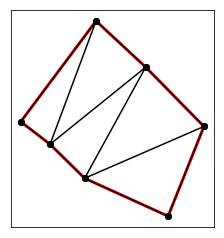

In [53]:
%timeit
procrustes_contour=apply_procrustes(generate_contour(7))
procrustes_contour=procrustes_contour.reshape(2*procrustes_contour.shape[0]).reshape(1,-1)
contour_transformed=pca.transform(procrustes_contour)

input_contour=Variable(torch.from_numpy(contour_transformed).type(torch.FloatTensor)).cuda()
predicted_quality_matrix=network7(input_contour)

predicted_quality_matrix=predicted_quality_matrix.cpu()
predicted_quality_matrix=predicted_quality_matrix.data[0].numpy().reshape(7,7)
procrustes_contour=procrustes_contour.reshape(7,2)
ordered_matrix=order_quality_matrix(predicted_quality_matrix,procrustes_contour)
triangulate(procrustes_contour,ordered_matrix)



initial set edges: {(0, 1), (1, 2), (4, 5), (5, 6), (6, 0), (2, 3), (3, 4)}
Edge: (6, 0) targeting: 5
(6, 0, 5)
Vertex locked: 6
edges inserted: (0, 5)
set of interior edges updated: {(0, 5)}
set of edges updated: {(0, 1), (1, 2), (4, 5), (5, 6), (6, 0), (2, 3), (0, 5), (3, 4)}
element inserted: (6, 0, 5)
Edge: (5, 6) targeting: 1
found (5, 0) (6, 0) Canceling creation
Edge: (5, 6) targeting: 0
(5, 6, 0)
Element (6, 0, 5) already in set
Edge: (4, 5) targeting: 1
(4, 5, 1)
edges inserted: (4, 1)
set of interior edges updated: {(4, 1), (0, 5)}
set of edges updated: {(0, 1), (1, 2), (4, 1), (4, 5), (5, 6), (6, 0), (2, 3), (0, 5), (3, 4)}
edges inserted: (5, 1)
set of interior edges updated: {(5, 1), (4, 1), (0, 5)}
set of edges updated: {(0, 1), (1, 2), (4, 1), (4, 5), (5, 6), (6, 0), (2, 3), (0, 5), (5, 1), (3, 4)}
element inserted: (4, 5, 1)
Edge: (3, 4) targeting: 2
(3, 4, 2)
Vertex locked: 3
edges inserted: (4, 2)
set of interior edges updated: {(4, 2), (5, 1), (4, 1), (0, 5)}
set of 

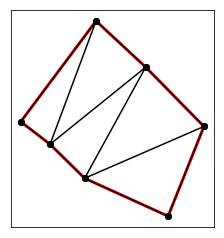

In [54]:
original_quality_matrix,_=quality_matrix(procrustes_contour)
ordered_matrix=order_quality_matrix(original_quality_matrix,procrustes_contour)
triangulate(procrustes_contour,ordered_matrix)


In [47]:
start_time=time.time()
# Perform procrustes
time1=time.time()
procrustes_contour=apply_procrustes(contour)
procrustes_time=time.time() - time1
print("Elapsed time for applying procrustes --- %s seconds ---" % (procrustes_time))


procrustes_contour=procrustes_contour.reshape(2*contour.shape[0]).reshape(1,-1)



# Project to space 
time2=time.time()
contour_transformed=pca.transform(procrustes_contour)
projection_time=time.time() - time2
print("Elapsed time for projection --- %s seconds ---" % (projection_time))


# Fire to network
time3=time.time()
input_contour=Variable(torch.from_numpy(contour_transformed).type(torch.FloatTensor)).cuda()
predicted_quality_matrix=network9(input_contour)
network_time=time.time() - time3
print("Elapsed time for getting quality matrix from neural net --- %s seconds ---" % (network_time))

predicted_quality_matrix=predicted_quality_matrix.cpu()
predicted_quality_matrix=predicted_quality_matrix.data[0].numpy().reshape(9,9)
procrustes_contour=procrustes_contour.reshape(9,2)


# Calculating quality matrix
time4=time.time()
original_quality_matrix,_=quality_matrix(procrustes_contour)
calculation_quality_matrix_time=time.time() - time4
print("Elapsed time for calculating original quality matrix  --- %s seconds ---" % (calculation_quality_matrix_time))


# Ordering quality matrix
time5=time.time()
ordered_matrix=order_quality_matrix(original_quality_matrix,procrustes_contour)
ordering_matrix_time=time.time() - time5
print("Elapsed time for ordering the quality matrix  --- %s seconds ---" % (ordering_matrix_time))


# Triangulation
time6=time.time()
triangulate(procrustes_contour,ordered_matrix)
triangulation_time=time.time() - time6
print("Elapsed time to triangulate according to matrix   --- %s seconds ---" % (triangulation_time))




print("Total time  of triangulation with calculation of matrix :   --- %s seconds ---" % ( (procrustes_time+calculation_quality_matrix_time
                                                                                      +ordering_matrix_time+triangulation_time)))

print("Total time  of triangulation using neural network :   --- %s seconds ---" % ( (procrustes_time+projection_time
                                                                                      +network_time+triangulation_time)))



Elapsed time for applying procrustes --- 0.0009884834289550781 seconds ---


D:\Users\papagian\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:93: RuntimeWarning: invalid value encountered in true_divide
D:\Users\papagian\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:94: RuntimeWarning: invalid value encountered in true_divide


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [256]:
# Triangulate using the library 
time7=time.time()
shape=dict(vertices=procrustes_contour,segments=get_contour_edges(procrustes_contour))
t = triangle.triangulate(shape, 'pq0')
plot.plot(plt.axes(), **t)
print("Elapsed time to triangulate using triangle module   --- %s seconds ---" % (time.time() - time7))


ValueError: Input must have at least three input vertices.

In [146]:
def run_time_test(start,finish):
    
    times=np.empty([int(((finish+1)-start)),9])

    for index,i in enumerate(range(start,finish+1)):
        
        # train to project with pca
        Polygons=load_dataset(str(i)+'_polygons.pkl')
    
        Polygons_reshaped=[]
        for j in range(Polygons.shape[0]):
            Polygons_reshaped.append(Polygons[j].reshape(2*i))

        Polygons_reshaped=np.array(Polygons_reshaped) 
        
                        # PCA   #
        pca=PCA(.999)
        pca.fit(Polygons_reshaped)
        Polygons_projected=pca.transform(Polygons_reshaped)

        
        contour=generate_contour(i)
        
        network=load_network(str(i)+'_neural_net.pkl')
        start_time=time.time()
        
        
        
        
        
        
        # Perform procrustes
        time1=timer()
        procrustes_contour=apply_procrustes(contour)
        procrustes_time=timer() - time1
        print("Elapsed time for applying procrustes --- %s seconds ---" % (procrustes_time))
        
        
        procrustes_contour=procrustes_contour.reshape(2*contour.shape[0]).reshape(1,-1)
        
        
        
        # Project to space 
        time2=timer()
        contour_transformed=pca.transform(procrustes_contour)
        projection_time=timer() - time2
        print("Elapsed time for projection --- %s seconds ---" % (projection_time))
        
        
        # Fire to network
        time3=timer()
        input_contour=Variable(torch.from_numpy(contour_transformed).type(torch.FloatTensor)).cuda()
        predicted_quality_matrix=network(input_contour)
        network_time=timer() - time3
        print("Elapsed time for getting quality matrix from neural net --- %s seconds ---" % (network_time))
        
        predicted_quality_matrix=predicted_quality_matrix.cpu()
        predicted_quality_matrix=predicted_quality_matrix.data[0].numpy().reshape(i,i)
        procrustes_contour=procrustes_contour.reshape(i,2)
        
        
        # Calculating quality matrix
        time4=timer()
        original_quality_matrix,_=quality_matrix(procrustes_contour)
        calculation_quality_matrix_time=timer() - time4
        print("Elapsed time for calculating original quality matrix  --- %s seconds ---" % (calculation_quality_matrix_time))
        
        
        # Ordering quality matrix
        time5=timer()
        ordered_matrix=order_quality_matrix(original_quality_matrix,procrustes_contour)
        ordering_matrix_time=timer() - time5
        print("Elapsed time for ordering the quality matrix  --- %s seconds ---" % (ordering_matrix_time))
        
        
        # Triangulation
        time6=timer()
        pure_triangulate(procrustes_contour,ordered_matrix,recursive=True)
        triangulation_time=timer() - time6
        print("Elapsed time to triangulate according to matrix   --- %s seconds ---" % (triangulation_time))
        
        
        total_time_with_calculation=(procrustes_time+calculation_quality_matrix_time+ordering_matrix_time+triangulation_time)
        print("Total time  of triangulation with calculation of matrix :   --- %s seconds ---" % (total_time_with_calculation ))
        total_time_with_NN=(procrustes_time+projection_time+network_time+triangulation_time)
        print("Total time  of triangulation using neural network :   --- %s seconds ---" % ( total_time_with_NN))


        
        # Triangulate using the library 
        shape=dict(vertices=procrustes_contour,segments=get_contour_edges(procrustes_contour))
        time7=timer()
        for i in range(10000):
            t = triangle.triangulate(shape, 'pq0')
        remeshing_time=timer()-time7
        remeshing_time/=10000

        #plot.plot(plt.axes(), **t) 
        print("Elapsed time to triangulate using triangle module   --- %s seconds ---" % (remeshing_time))
        times[index]=[procrustes_time,projection_time,network_time,calculation_quality_matrix_time,ordering_matrix_time,triangulation_time,total_time_with_calculation,total_time_with_NN,remeshing_time]
    return times

In [147]:
times4=np.empty([20,9])
for j in range(20):
    time_elapsed=run_time_test(4,4)
    times4[j]=time_elapsed
times5=np.empty([20,9])
for j in range(20):
    time_elapsed=run_time_test(5,5)
    times5[j]=time_elapsed
    
times6=np.empty([20,9])
for j in range(20):
    time_elapsed=run_time_test(6,6)
    times6[j]=time_elapsed
    
times7=np.empty([20,9])
for j in range(20):
    time_elapsed=run_time_test(7,7)
    times7[j]=time_elapsed
    
times8=np.empty([20,9])
for j in range(20):
    time_elapsed=run_time_test(8,8)
    times8[j]=time_elapsed
    
times9=np.empty([20,9])
for j in range(20):
    time_elapsed=run_time_test(9,9)
    times9[j]=time_elapsed
    

Elapsed time for applying procrustes --- 0.00032223501011685585 seconds ---
Elapsed time for projection --- 0.0001631666941648291 seconds ---
Elapsed time for getting quality matrix from neural net --- 0.0006677795472569414 seconds ---
Elapsed time for calculating original quality matrix  --- 0.13363634011739123 seconds ---
Elapsed time for ordering the quality matrix  --- 0.0003150628472212702 seconds ---
Elapsed time to triangulate according to matrix   --- 0.0010122994899575133 seconds ---
Total time  of triangulation with calculation of matrix :   --- 0.13528593746468687 seconds ---
Total time  of triangulation using neural network :   --- 0.0021654807414961397 seconds ---
Elapsed time to triangulate using triangle module   --- 5.345530449285434e-05 seconds ---
Elapsed time for applying procrustes --- 0.00037115940313015017 seconds ---
Elapsed time for projection --- 0.0001813532489904901 seconds ---
Elapsed time for getting quality matrix from neural net --- 0.0007092756295605795 

KeyboardInterrupt: 

In [142]:
times_elapsed_mean=np.array([times4.mean(0),times5.mean(0),times6.mean(0),times7.mean(0),times8.mean(0),times9.mean(0)])
times_elapsed_std=np.array([times4.std(0),times5.std(0),times6.std(0),times7.std(0),times8.std(0),times9.std(0)])

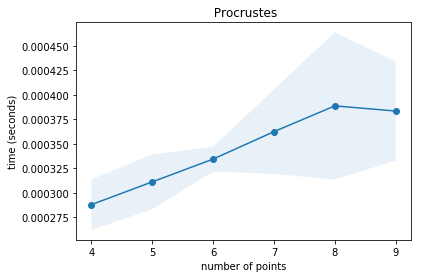

In [143]:
procrustes_time_graph=plt.plot(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,0],marker='o')
plt.fill_between(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,0]-times_elapsed_std[:,0],times_elapsed_mean[:,0]+times_elapsed_std[:,0],alpha=.1)
plt.title(' Procrustes')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')

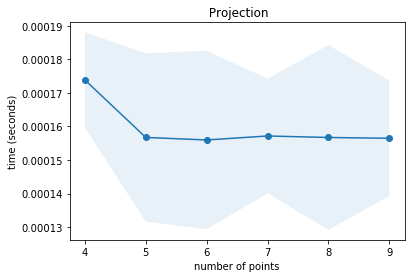

In [536]:
projection_time_graph=plt.plot(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,1],marker='o')
plt.fill_between(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,1]-times_elapsed_std[:,1],times_elapsed_mean[:,1]+times_elapsed_std[:,1],alpha=.1)

plt.title(' Projection')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')

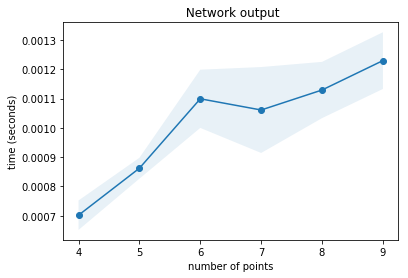

In [537]:
network_time_graph=plt.plot(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,2],marker='o')
plt.fill_between(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,2]-times_elapsed_std[:,2],times_elapsed_mean[:,2]+times_elapsed_std[:,2],alpha=.1)

plt.title(' Network output')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')

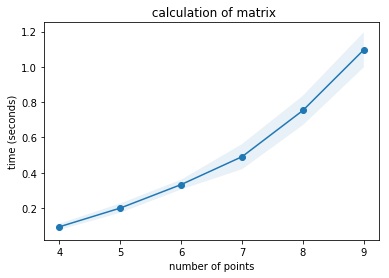

In [538]:
calculation_matrix_graph=plt.plot(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,3],marker='o')
plt.fill_between(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,3]-times_elapsed_std[:,3],times_elapsed_mean[:,3]+times_elapsed_std[:,3],alpha=.1)

plt.title(' calculation of matrix')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')

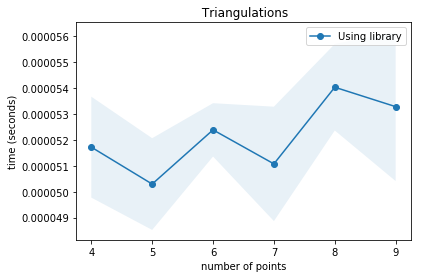

In [593]:
#triangulation_graph_with_calculation=plt.plot(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,6],marker='o',label='Calculation of matrix')
#triangulation_graph_with_NN=plt.plot(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,5],marker='o',label='Our method')
#plt.fill_between(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,5]-times_elapsed_std[:,5],times_elapsed_mean[:,5]+times_elapsed_std[:,5],alpha=.1)

triangulation_graph_with_library=plt.plot(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,8],marker='o',label='Using library')
plt.fill_between(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,8]-times_elapsed_std[:,8],times_elapsed_mean[:,8]+times_elapsed_std[:,8],alpha=.1)

plt.legend()
plt.title(' Triangulations')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')





In [13]:
o=3.5

In [14]:
np.round(o)
        

4.0

In [182]:
nb_of_contours=100
contours=[generate_contour(i) for i in range(4,nb_of_contours) ]
processing_ctimes=np.empty([int(nb_of_contours-4)])
processing_timer=np.empty([int(nb_of_contours-4)])
processing_time=np.empty([int(nb_of_contours-4)])

In [183]:


for index,j in enumerate(range(4,nb_of_contours)):
    contour=contours[index]
    shape=dict(vertices=contour,segments=get_contour_edges(contour))
    
    time1=ctimer.start()
    for i in range(1000):
        triangulated=triangle.triangulate(shape,'pq0')  
    time2=ctimer.stop()
    remeshing_time=(ctimer.diff(time2,time1))*10**(-9)
    
    processing_ctimes[index]=remeshing_time


In [184]:

for index,j in enumerate(range(4,nb_of_contours)):
    contour=contours[index]

    shape=dict(vertices=contour,segments=get_contour_edges(contour))
    
    time1=timer()
    for i in range(1000):
        triangulated=triangle.triangulate(shape,'pq0')  
    time2=timer()
    remeshing_time=time2-time1
    
    processing_timer[index]=remeshing_time
    

In [185]:
for index,j in enumerate(range(4,nb_of_contours)):
    contour=contours[index]

    
    shape=dict(vertices=contour,segments=get_contour_edges(contour))
    
    time1=time.perf_counter()
    for i in range(1000):
        triangulated=triangle.triangulate(shape,'pq0')  
    time2=time.perf_counter()
    remeshing_time=time2-time1
    
    processing_time[index]=remeshing_time

(array([ 0.06760359,  0.05959082,  0.05308127,  0.05258083,  0.05258036,
         0.04657149,  0.05558467,  0.05308199,  0.05758834,  0.05458331,
         0.06159472,  0.05308104,  0.05308199,  0.0565865 ,  0.04506946,
         0.06059241,  0.05308175,  0.05108547,  0.06309676,  0.06059265,
         0.06309676,  0.063097  ,  0.06359696,  0.06710291,  0.07211065,
         0.06810474,  0.08412838,  0.07261181,  0.0751152 ,  0.08112407,
         0.07862043,  0.08863616,  0.1011548 ,  0.10365868,  0.07561564,
         0.07811999,  0.07862091,  0.07361293,  0.07711792,  0.07962227,
         0.076617  ,  0.07661748,  0.07661724,  0.0560863 ,  0.05458379,
         0.08563089,  0.08563137,  0.08763433,  0.08162498,  0.07862115,
         0.0826261 ,  0.08663273,  0.09564686,  0.08412933,  0.0906384 ,
         0.0951457 ,  0.10365939,  0.09814978,  0.11016965,  0.10466003,
         0.1076653 ,  0.11066961,  0.11016917,  0.12018418,  0.11116982,
         0.10516119,  0.11317372,  0.11317348,  0.1

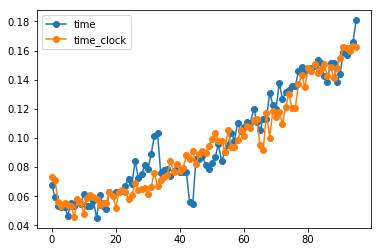

In [186]:
plt.plot(processing_time,marker='o',label='time')
#plt.plot(processing_ctimes,marker='x')
plt.plot(processing_timer,marker='o',label='time_clock')
plt.legend()
processing_time,processing_timer,processing_ctimes

# 

remeshing time : 0.0022776704


NameError: name 'triangulated' is not defined

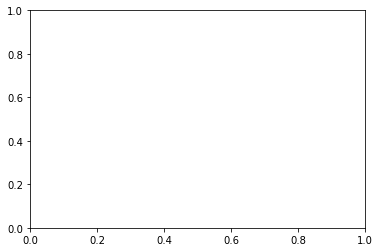

In [17]:
shape=dict(vertices=contour,segments=get_contour_edges(contour))

time1=timer()
Delaunay(contour)

time2=timer()

print("remeshing time : %.10f"%((time2-time1)))
plot.plot(plt.axes(), **triangulated)


In [29]:
from Delaunay_2d import Delaunay2d
from scipy.spatial import Delaunay


qualities=[]
for j in range(4,30):
    print(j)
    contour=get_reference_polygon(j)
    quality,_=quality_matrix(contour)
    qualities.append(quality)




4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [44]:
time_delaunay=[]
time_triangulation=[]


for index,j in enumerate(range(4,30)):
    nb_of_repetitions=100
    print("{} point polygon".format(j))
    contour = [np.array([i[0],i[1]]) for i in get_reference_polygon(j)]
    start=timer()
    for i in range(nb_of_repetitions):
        delaunay = Delaunay2d(contour)
    stop=timer()
    delaunay_remeshing_time=(stop-start)/nb_of_repetitions
    print("Elapsed time using Delaunay: %f"%(delaunay_remeshing_time))
    time_delaunay.append(delaunay_remeshing_time)
    
    
    contour=get_reference_polygon(j)
    quality=qualities[index]
    ordered_matrix=order_quality_matrix(quality,contour)
    start=timer()
    for i in range(nb_of_repetitions):
        pure_triangulate(contour,ordered_matrix,recursive=False)
    stop=timer()
    construction_from_matrix_time=(stop-start)/nb_of_repetitions
    print("Elapsed time using my method: %f"%(construction_from_matrix_time))
    time_triangulation.append(construction_from_matrix_time)
    


4 point polygon
Elapsed time using Delaunay: 0.000068
Elapsed time using my method: 0.000584
5 point polygon
Elapsed time using Delaunay: 0.000096
Elapsed time using my method: 0.000880
6 point polygon
Elapsed time using Delaunay: 0.000164
Elapsed time using my method: 0.001135
7 point polygon
Elapsed time using Delaunay: 0.000222
Elapsed time using my method: 0.001502
8 point polygon
Elapsed time using Delaunay: 0.000295
Elapsed time using my method: 0.002021
9 point polygon
Elapsed time using Delaunay: 0.000393
Elapsed time using my method: 0.002831
10 point polygon
Elapsed time using Delaunay: 0.000508
Elapsed time using my method: 0.003020
11 point polygon
Elapsed time using Delaunay: 0.000637
Elapsed time using my method: 0.004245
12 point polygon
Elapsed time using Delaunay: 0.000751
Elapsed time using my method: 0.004978
13 point polygon
Elapsed time using Delaunay: 0.000887
Elapsed time using my method: 0.007775
14 point polygon
Elapsed time using Delaunay: 0.001031
Elapsed tim

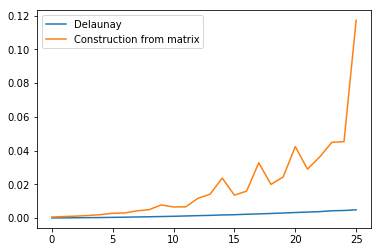

In [45]:
plt.plot(time_delaunay[:],label='Delaunay') 
#plt.plot(time_scipy_triangulation[:],label='Scipy  Delaunay')
plt.plot(time_triangulation[:],label='Construction from matrix')

plt.legend()

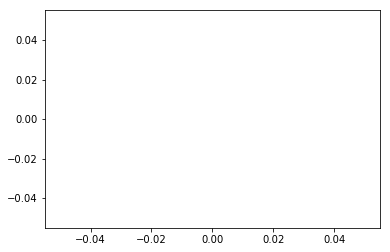

In [266]:
plt.plot(np.array(time_delaunay)/np.array(time_triangulation))

In [84]:


tri=Delaunay(contour)


array([[ 1.        ,  0.        ],
       [ 0.9819287 ,  0.18925124],
       [ 0.92836793,  0.37166246],
       [ 0.84125353,  0.54064082],
       [ 0.72373404,  0.69007901],
       [ 0.58005691,  0.81457595],
       [ 0.41541501,  0.909632  ],
       [ 0.23575894,  0.97181157],
       [ 0.04758192,  0.99886734],
       [-0.14231484,  0.98982144],
       [-0.32706796,  0.94500082],
       [-0.5       ,  0.8660254 ],
       [-0.65486073,  0.75574957],
       [-0.78605309,  0.61815899],
       [-0.88883545,  0.45822652],
       [-0.95949297,  0.28173256],
       [-0.99547192,  0.09505604],
       [-0.99547192, -0.09505604],
       [-0.95949297, -0.28173256],
       [-0.88883545, -0.45822652],
       [-0.78605309, -0.61815899],
       [-0.65486073, -0.75574957],
       [-0.5       , -0.8660254 ],
       [-0.32706796, -0.94500082],
       [-0.14231484, -0.98982144],
       [ 0.04758192, -0.99886734],
       [ 0.23575894, -0.97181157],
       [ 0.41541501, -0.909632  ],
       [ 0.58005691,

In [40]:
from Triangulation import check_ordered_matrix



In [41]:
contour=read_contour('23_polygon')
triangulate(contour,check_ordered_matrix(order_quality_matrix(quality_matrix(contour)[0],contour),contour),recursive=True)


NameError: name 'get_contour_edges' is not defined

In [527]:
export_contour('23_polygon',contour)

NameError: name 'plot_contour' is not defined

In [14]:
polygons=load_dataset('12_polygons.pkl')

In [15]:
polygon.shape[0]

60000

In [ ]:
60.